Siamdhani Nurcahyo
siamdhani.nurcahyo1@gmail.com

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import re
import string

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
reviews = pd.get_dummies(df.sentiment)
df_baru = pd.concat([df, reviews], axis = 1)
df_baru = df_baru.drop(columns=['sentiment'])
df_baru

,review,negative,positive
0,One of the other reviewers has mentioned that ...,0,1
1,A wonderful little production. <br /><br />The...,0,1
2,I thought this was a wonderful way to spend ti...,0,1
3,Basically there's a family where a little boy ...,1,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0,1
...,...,...,...
49995,I thought this movie did a down right good job...,0,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",1,0
49997,I am a Catholic taught in parochial elementary...,1,0
49998,I'm going to have to disagree with the previou...,1,0


In [ ]:
def clean(text):
    
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ',text)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)

    filtered_sentence  = [word for word in word_tokens if not word in stop_words]
    text = (" ").join(filtered_sentence)

    splt = text.split(' ')
    output = [x for x in splt if len(x) > 3] #removing words with length<=3
    text = (" ").join(output)
     
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) #removing single character 
    text = re.sub('<.*?>+',' ',text) #removing HTML Tags
    text = re.sub('\n', ' ',text) #removal of new line characters
    text = re.sub(r'\s+', ' ',text) #removal of multiple spaces

    return text

In [ ]:
df_baru['review'] = df_baru['review'].apply(clean)

In [ ]:
reviews = df_baru['review'].values
label = df_baru[['negative', 'positive']].values

In [ ]:
reviews_latih, reviews_test, label_latih, label_test = train_test_split(reviews, label, test_size=0.2)

In [ ]:
tokenizer = Tokenizer(num_words = 5000, oov_token = 'x')
tokenizer.fit_on_texts(reviews_latih)
tokenizer.fit_on_texts(reviews_test)

sequence_latih = tokenizer.texts_to_sequences(reviews_latih)
sequence_test = tokenizer.texts_to_sequences(reviews_test)

padded_latih = pad_sequences(sequence_latih)
padded_test = pad_sequences(sequence_test)

In [ ]:
model = tf.keras.Sequential([
           tf.keras.layers.Embedding(input_dim = 5000, output_dim = 16),
           tf.keras.layers.LSTM(128, return_sequences = True),
           tf.keras.layers.Dropout(0.6),
           tf.keras.layers.LSTM(128),
           tf.keras.layers.Dense(512, activation = 'relu'),
           tf.keras.layers.Dense(256, activation = 'relu'),
           tf.keras.layers.Dense(2, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          80000     
                                                                 
 lstm_5 (LSTM)               (None, None, 128)         74240     
                                                                 
 dropout_3 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 512)               66048     
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 2)                

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
Accuracy_Threshold = 0.90
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') >= Accuracy_Threshold and logs.get('val_accuracy') >= Accuracy_Threshold):   
          print('\n')
          print('Epoch: ',epoch)
          print("\nReached %2.2f%% accuracy, training stopped!!" %(Accuracy_Threshold*100))   
          self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(padded_latih, 
                    label_latih,
                    epochs = 30,
                    validation_data = (padded_test, label_test),
                    verbose = 2,
                    callbacks = [callbacks])

Epoch 1/30
1250/1250 - 133s - loss: 0.4124 - accuracy: 0.8075 - val_loss: 0.3228 - val_accuracy: 0.8612 - 133s/epoch - 106ms/step
Epoch 2/30
1250/1250 - 123s - loss: 0.2774 - accuracy: 0.8872 - val_loss: 0.2906 - val_accuracy: 0.8794 - 123s/epoch - 99ms/step
Epoch 3/30
1250/1250 - 123s - loss: 0.2527 - accuracy: 0.8992 - val_loss: 0.3053 - val_accuracy: 0.8727 - 123s/epoch - 98ms/step
Epoch 4/30
1250/1250 - 122s - loss: 0.2293 - accuracy: 0.9099 - val_loss: 0.3138 - val_accuracy: 0.8773 - 122s/epoch - 98ms/step
Epoch 5/30
1250/1250 - 123s - loss: 0.2053 - accuracy: 0.9211 - val_loss: 0.3603 - val_accuracy: 0.8748 - 123s/epoch - 98ms/step
Epoch 6/30
1250/1250 - 123s - loss: 0.1792 - accuracy: 0.9327 - val_loss: 0.3346 - val_accuracy: 0.8710 - 123s/epoch - 98ms/step
Epoch 7/30
1250/1250 - 123s - loss: 0.1606 - accuracy: 0.9414 - val_loss: 0.3855 - val_accuracy: 0.8693 - 123s/epoch - 98ms/step
Epoch 8/30
1250/1250 - 123s - loss: 0.1442 - accuracy: 0.9484 - val_loss: 0.3419 - val_accuracy:

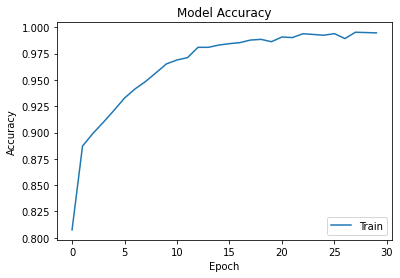

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='lower right')
plt.show()

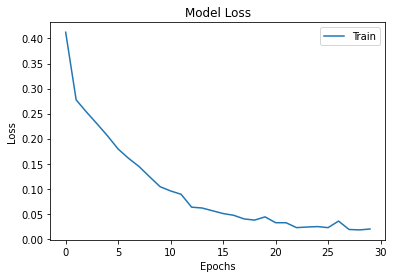

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper right')
plt.show()